<a href="https://colab.research.google.com/github/thaCripple/SkinLesionClassifier_v2/blob/main/maxvit_t_slc_v2_TheModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Skin Lession Classifier v2

[MaxViT_t](https://pytorch.org/vision/main/models/generated/torchvision.models.maxvit_t.html#torchvision.models.maxvit_t) model, fine-tuned on the [HAM10000](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DBW86T) data set for pigmented skin lesion classification

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
import torchvision
from torchvision.transforms import v2
from pathlib import Path
from PIL import Image
import json
import random
import os
import time
import tempfile

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
!pip install -q lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 818.9/818.9 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 48.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torchmetrics

In [ ]:
from lightning.fabric import Fabric

In [ ]:
if not Path.is_file(Path("/content/skin_lesions.zip")):
  !cp "/content/drive/MyDrive/skin_lesions.zip" "/content"
  if not Path.is_dir(Path("/content/skin_lesions")):
    !unzip -q "/content/skin_lesions.zip" -d "/content"

In [ ]:
IMGS_ROOT = Path("/content/skin_lesions")

In [ ]:
train_imgs_dir = IMGS_ROOT / "train"
train_metadata_path = Path("/content/drive/MyDrive/skin_lesion_classifier_v2/train_metadata.csv")
test_imgs_dir = IMGS_ROOT / "test"
test_metadata_path = Path("/content/drive/MyDrive/skin_lesion_classifier_v2/test_metadata.csv")

# Check the data

In [ ]:
sns.set_style(style="whitegrid")

In [ ]:
train_metadata = pd.read_csv(train_metadata_path)
train_metadata

,image_name,class_name,original
0,ISIC_0024329.jpg,akiec,True
1,ISIC_0024372.jpg,akiec,True
2,ISIC_0024418.jpg,akiec,True
3,ISIC_0024450.jpg,akiec,True
4,ISIC_0024463.jpg,akiec,True
...,...,...,...
23260,aug_ISIC_0035931_526.jpg,vasc,False
23261,aug_ISIC_0035925_527.jpg,vasc,False
23262,aug_ISIC_0035946_528.jpg,vasc,False
23263,aug_ISIC_0035952_529.jpg,vasc,False


Number of training samples per class

In [ ]:
samples_per_class = train_metadata['class_name'].value_counts()
samples_per_class

,count
class_name,
nv,7613
bkl,5264
mel,5136
bcc,2428
akiec,1480
vasc,708
df,636


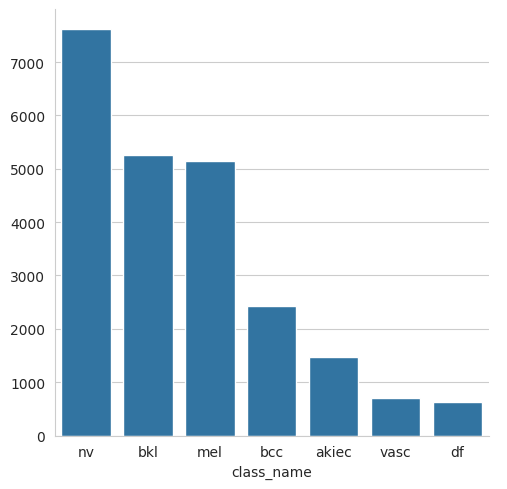

In [ ]:
samples_per_class_plot = sns.catplot(kind="bar", x=samples_per_class.index, y=samples_per_class.values)
samples_per_class_plot

Number of original and generated samples per class

In [ ]:
original_samples_per_class = train_metadata.groupby(by=['class_name', "original"]).count()
original_samples_per_class

image_name
class_name original            
akiec      False           1110
           True             370
bcc        False           1821
           True             607
bkl        False           3948
           True            1316
df         False            477
           True             159
mel        False           3852
           True            1284
nv         True            7613
vasc       False            531
           True             177

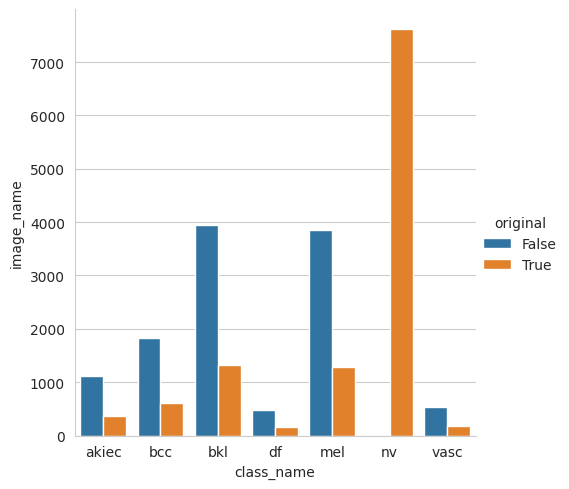

In [ ]:
sns.catplot(kind="bar", data=original_samples_per_class.reset_index(level=1), x="class_name", y="image_name", hue="original")

# Create DataLoaders

Model specific image transforms

In [ ]:
transforms = torchvision.models.MaxVit_T_Weights.IMAGENET1K_V1.transforms()
transforms

ImageClassification(
    crop_size=[224]
    resize_size=[224]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [ ]:
BATCH_SIZE = 52
WORKERS = os.cpu_count()
WORKERS

2

In [ ]:
train_ds = torchvision.datasets.ImageFolder(root=train_imgs_dir, transform=transforms)
train_dl = torch.utils.data.DataLoader(dataset=train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=WORKERS, pin_memory=True, prefetch_factor=1, drop_last=True)

In [ ]:
test_ds = torchvision.datasets.ImageFolder(root=test_imgs_dir, transform=transforms)
test_dl = torch.utils.data.DataLoader(dataset=test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKERS, pin_memory=True, prefetch_factor=1, drop_last=True)

## Visualize some transformed images

In [ ]:
cols = 3
rows = 2
fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(4*cols, 4*rows))

for i in range(rows):

  # Show 2 random train imgs
  train_imgs_batch, train_imgs_label = next(iter(train_dl))
  # Move the channel dimension to the last position (H, W, C)
  train_img1 = torch.movedim(input=train_imgs_batch[0], source=0, destination=-1)
  train_img1_lbl = train_ds.classes[train_imgs_label[0]]
  train_img2 = torch.movedim(input=train_imgs_batch[1], source=0, destination=-1)
  train_img2_lbl = train_ds.classes[train_imgs_label[1]]

  ax[i,0].imshow(train_img1)
  ax[i,0].axis(False)
  ax[i,0].set(title=train_img1_lbl)

  ax[i,1].imshow(train_img2)
  ax[i,1].set_title(train_img2_lbl)
  ax[i,1].axis(False)

  # Show a random test img
  test_imgs_batch, test_imgs_label = next(iter(test_dl))
  test_idx = random.randint(0, BATCH_SIZE-1)
  test_img1 = torch.movedim(input=test_imgs_batch[test_idx], source=0, destination=-1)
  test_img1_lbl = test_ds.classes[test_imgs_label[test_idx]]
  ax[i,2].imshow(test_img1)
  ax[i,2].set_title(test_img1_lbl)
  ax[i,2].axis(False)

fig.set(layout_engine="compressed")
fig.show()

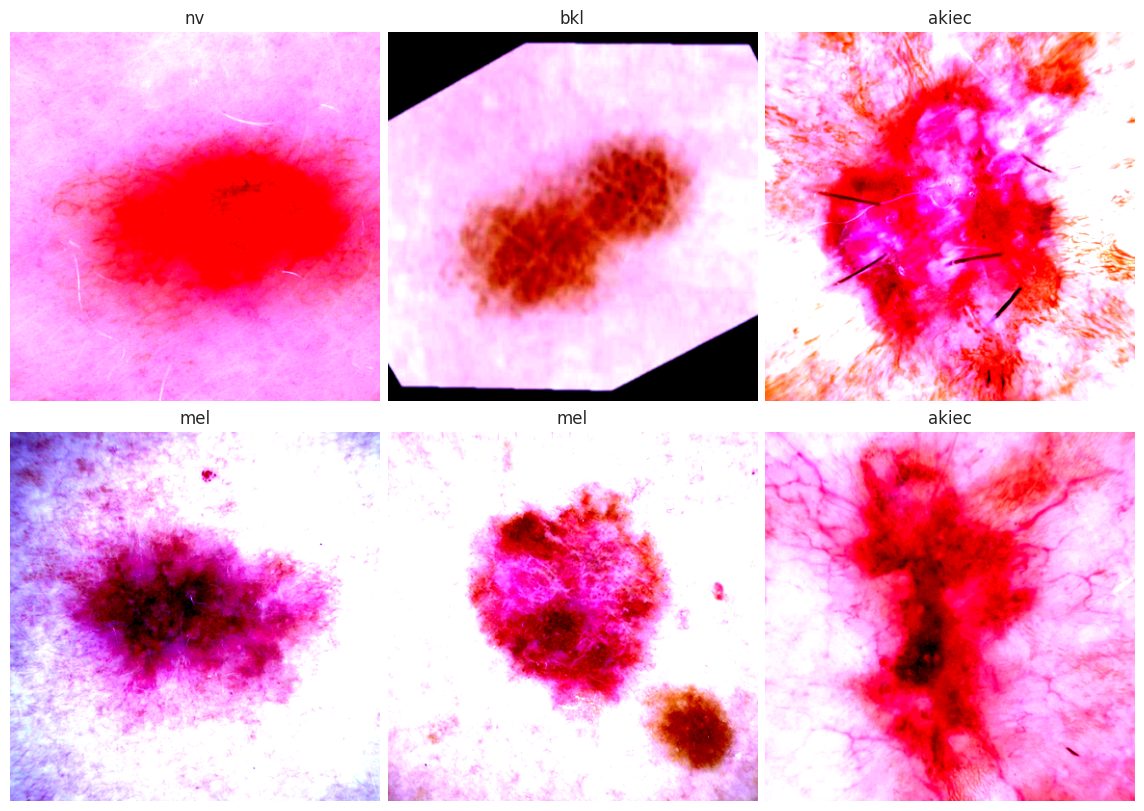

# Instantiate the model
I am using PyTorch's implementation of the MaxVit_T architecture as the base for the model and referencing the original [research paper](https://arxiv.org/abs/2204.01697) for hyperparameters

## Get the base model

In [ ]:
maxvit_t = torchvision.models.maxvit_t(weights='DEFAULT')

Downloading: "https://download.pytorch.org/models/maxvit_t-bc5ab103.pth" to /root/.cache/torch/hub/checkpoints/maxvit_t-bc5ab103.pth
100%|██████████| 119M/119M [00:00<00:00, 125MB/s]


In [ ]:
maxvit_t.classifier

Sequential(
  (0): AdaptiveAvgPool2d(output_size=1)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (3): Linear(in_features=512, out_features=512, bias=True)
  (4): Tanh()
  (5): Linear(in_features=512, out_features=1000, bias=False)
)

In [ ]:
head_in_features = maxvit_t.classifier[-1].in_features
head_in_features

512

### Overwrite the Linear layer

In [ ]:
maxvit_t.classifier[-1] = nn.Linear(in_features=head_in_features, out_features=7, bias=False)
maxvit_t.classifier

Sequential(
  (0): AdaptiveAvgPool2d(output_size=1)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (3): Linear(in_features=512, out_features=512, bias=True)
  (4): Tanh()
  (5): Linear(in_features=512, out_features=7, bias=False)
)

## Assign the loss function
Additinaly specify class weights to negate the fact that the dataset is still quite imbalanced even after oversampling

In [ ]:
def create_loss_fn(verbose:bool=False)->nn.CrossEntropyLoss:
  """
  Calculates class weights and returns a loss function with the weights applied

  # Parameters
  verbose: print calculated weights so I can make sure they make sense

  # Returns
  nn.CrossEntropyLoss with class weights applied
  """
  y_train = train_metadata['class_name'].to_numpy()
  unique_classes = np.unique(y_train)
  class_weights_arr = compute_class_weight(class_weight="balanced", classes=unique_classes, y=y_train)
  class_weights = torch.from_numpy(class_weights_arr).to(dtype=torch.float32)
  if verbose:
    print(class_weights)
    print(train_ds.classes)
    print(train_metadata['class_name'].value_counts())

  return nn.CrossEntropyLoss(weight=class_weights)

In [ ]:
create_loss_fn(verbose=True)

tensor([2.2457, 1.3689, 0.6314, 5.2257, 0.6471, 0.4366, 4.6943])
['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
class_name
nv       7613
bkl      5264
mel      5136
bcc      2428
akiec    1480
vasc      708
df        636
Name: count, dtype: int64


CrossEntropyLoss()

In [ ]:
maxvit_t_loss_fn = create_loss_fn()
maxvit_t_loss_fn

CrossEntropyLoss()

## Define the optimizer

In [ ]:
maxvit_t_optimizer = torch.optim.AdamW(params=maxvit_t.parameters(), lr=2e-4, weight_decay=.05)

# Define the training functions

## train_step function

In [ ]:
def train_step(model:nn.Module, train_dl:torch.utils.data.DataLoader, loss_fn:nn.modules.loss,
               optimizer:torch.optim, accuracy_fn:torchmetrics.classification.MulticlassAccuracy, fabric:Fabric)->tuple:

  total_epoch_loss = 0
  total_epoch_accuracy = 0
  num_batches = len(train_dl)

  model.train()
  for batch_number, (x_batch, y_batch) in enumerate(train_dl):

    logits = model(x_batch)
    loss = loss_fn(logits, y_batch)
    total_epoch_loss += loss.item()

    accuracy = accuracy_fn(preds=logits, target=y_batch)
    total_epoch_accuracy += accuracy.item()

    optimizer.zero_grad()
    fabric.backward(loss)
    optimizer.step()

    if batch_number % 50 == 0:
      print(f" Batch {batch_number}/{num_batches}")

  mean_epoch_loss = total_epoch_loss / num_batches
  mean_epoch_accuracy = total_epoch_accuracy / num_batches

  return mean_epoch_loss, mean_epoch_accuracy

## test_step function

In [ ]:
def test_step(model:nn.Module, test_dl:torch.utils.data.DataLoader, loss_fn:nn.modules.loss,
              accuracy_fn:torchmetrics.classification.MulticlassAccuracy)->tuple:

  total_epoch_loss = 0
  total_epoch_accuracy = 0
  num_batches = len(test_dl)

  model.eval()
  with torch.inference_mode():
    for x_batch, y_batch in test_dl:

      logits = model(x_batch)
      loss = loss_fn(logits, y_batch)
      total_epoch_loss += loss.item()

      accuracy = accuracy_fn(preds=logits, target=y_batch)
      total_epoch_accuracy += accuracy.item()

  mean_epoch_loss = total_epoch_loss / num_batches
  mean_epoch_accuracy = total_epoch_accuracy / num_batches

  return mean_epoch_loss, mean_epoch_accuracy

## training loop function

In [ ]:
def train_model(model:nn.Module, train_dl:torch.utils.data.DataLoader, test_dl:torch.utils.data.DataLoader, loss_fn:nn.modules.loss,
               optimizer:torch.optim, accuracy_fn:torchmetrics.classification.MulticlassAccuracy, fabric:Fabric, epochs:int=1, save_path:Path|None=None, patience:int=10)->dict:

  train_metrics = {
      "train_loss": [],
      "train_accuracy": [],
      "test_loss": [],
      "test_accuracy": []}

  _checkpoint_save_path = Path("/content/drive/MyDrive/skin_lesion_classifier_v2/training_checkpoints")


  best_params_file = Path(_checkpoint_save_path, "best_params.pth")
  best_test_loss = 128
  best_epoch = 0
  remaining_patience = patience

  for epoch in range(epochs):
    epoch_start_time = time.time()
    print(f"Epoch {epoch}/{epochs-1}")

    train_loss, train_accuracy = train_step(model=model, train_dl=train_dl, loss_fn=loss_fn, optimizer=optimizer, accuracy_fn=accuracy_fn, fabric=fabric)
    test_loss, test_accuracy = test_step(model=model, test_dl=test_dl, loss_fn=loss_fn, accuracy_fn=accuracy_fn)

    train_metrics["train_loss"].append(train_loss)
    train_metrics["train_accuracy"].append(train_accuracy)
    train_metrics["test_loss"].append(test_loss)
    train_metrics["test_accuracy"].append(test_accuracy)

    print(f"Train loss: {train_loss:.3f} | Train Accuracy: {train_accuracy:.2f}")
    print(f"Test loss: {test_loss:.3f} | Test Accuracy: {test_accuracy:.2f}")
    print(f"Time taken {time.time() - epoch_start_time}s", end="\n\n")
    print("-"*80)

    if test_loss < best_test_loss:
      best_test_loss = test_loss
      best_epoch = epoch
      remaining_patience = patience
      torch.save(obj=model.state_dict(), f=best_params_file)
    else:
      remaining_patience -= 1

    if remaining_patience == 0:
      print(f"{'-'*30}[Early Stop]{'-'*30}")
      print(f"Saving best model weights from epoch: {best_epoch} with loss: {best_test_loss}")
      best_params_file.rename(save_path)
      break

  return train_metrics

# Train the model

In [ ]:
# Seems to auto detect the GPU
fabric = Fabric(accelerator="auto", devices="auto", strategy="auto")
fabric.device

device(type='cpu')

In [ ]:
EPOCHS = 50
accuracy_fn = torchmetrics.classification.MulticlassAccuracy(num_classes=7, average="micro")

In [ ]:
weights_save_path = Path("/content/drive/MyDrive/skin_lesion_classifier_v2", "slc_v2_weights.pth")
weights_save_path

PosixPath('/content/drive/MyDrive/skin_lesion_classifier_v2/slc_v2_weights.pth')

In [ ]:
## I don't think that's worth it for such a short run
# maxvit_t = torch.compile(maxvit_t.to(device=fabric.device))

In [ ]:
maxvit_t, optimizer = fabric.setup(maxvit_t, maxvit_t_optimizer)
train_dl, test_dl = fabric.setup_dataloaders(train_dl, test_dl)
maxvit_t_loss_fn = maxvit_t_loss_fn.to(device=fabric.device)
accuracy_fn = accuracy_fn.to(device=fabric.device)

In [ ]:
## Doesn't seem to do much actually
# def prime_model(model:nn.Module, data_loader:torch.utils.data.DataLoader)->None:
#   data_start_time = time.time()
#   x_batch, _ = next(iter(data_loader))
#   print(f"Time to read a batch: {time.time() - data_start_time}")
#   model_start_time = time.time()
#   model(x_batch)
#   print(f"Forward pass time: {time.time() - model_start_time}")

# prime_model(model=maxvit_t, data_loader=train_dl)

### Start training

In [ ]:
maxvit_t_history = train_model(model=maxvit_t, train_dl=train_dl, test_dl=test_dl, loss_fn=maxvit_t_loss_fn, optimizer=maxvit_t_optimizer,
                              accuracy_fn=accuracy_fn, fabric=fabric, epochs=50, save_path=weights_save_path, patience=5)

Epoch 0/49


W0409 03:48:39.137000 4492 torch/_inductor/utils.py:1137] [0/0] Not enough SMs to use max_autotune_gemm mode


*** Batch 0/484 ***
*** Batch 50/484 ***
*** Batch 100/484 ***
*** Batch 150/484 ***
*** Batch 200/484 ***
*** Batch 250/484 ***
*** Batch 300/484 ***
*** Batch 350/484 ***
*** Batch 400/484 ***
*** Batch 450/484 ***
Train loss: 0.621 | Train Accuracy: 0.77
Test loss: 0.422 | Test Accuracy: 0.84
Time taken 1181.99489736557s

--------------------------------------------------------------------------------
Epoch 1/49
*** Batch 0/484 ***
*** Batch 50/484 ***
*** Batch 100/484 ***
*** Batch 150/484 ***
*** Batch 200/484 ***
*** Batch 250/484 ***
*** Batch 300/484 ***
*** Batch 350/484 ***
*** Batch 400/484 ***
*** Batch 450/484 ***
Train loss: 0.238 | Train Accuracy: 0.89
Test loss: 0.203 | Test Accuracy: 0.92
Time taken 612.3713111877441s

--------------------------------------------------------------------------------
Epoch 2/49
*** Batch 0/484 ***
*** Batch 50/484 ***
*** Batch 100/484 ***
*** Batch 150/484 ***
*** Batch 200/484 ***
*** Batch 250/484 ***
*** Batch 300/484 ***
*** Batch 

## Save the fitted model

In [ ]:
model_save_path = Path("/content/drive/MyDrive/skin_lesion_classifier_v2", "slc_v2_model.pth")
model_save_path

In [ ]:
maxvit_t.load_state_dict(state_dict=torch.load("/content/best_params.pth"))
torch.save(obj=maxvit_t, f=model_save_path)

## Save the training history

In [ ]:
with open(file=Path("/content/drive/MyDrive/skin_lesion_classifier_v2", "maxvit_t_history.json"), mode="w") as hist_file:
  json.dump(obj=maxvit_t_history, fp=hist_file)

# Conclusions

1. `torch.compile()` + `lightning.Fabric` is **awesome**. The time increase for the 1st epoch for the compiled model is definitely quite noticable and for such a short run renders compiling not worthwhile, but the subsequent epochs are faster than with just `Fabric`
2. Learning about placing data in a single archive file and unzipping in session storage was Live Changing! Data retrieval is sooo much faster 😁
3. Learning about adjusting batch size and optimizer parameters helped me to limit the amount of ⬇

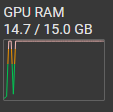

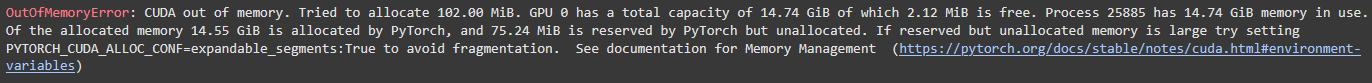